In [110]:
#!pip install keras
#!pip install tensorflow
#!pip install scikeras
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
#!pip install keras_tuner

In [111]:
import csv
import itertools
import warnings
import nltk
import pandas as pd
import sklearn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import GlorotNormal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
warnings.filterwarnings(action='ignore')

In [3]:
def simplified_preprocessing(filename):
    header = ["train_id", "Sentence_1", "Sentence_2", "Output"]
    df = pd.read_csv(filename, sep='\t', names=header, engine='python', encoding='utf8', error_bad_lines=False,
                     quoting=csv.QUOTE_NONE)
    # Make all words lowercase
    df['Sentence_1'] = df['Sentence_1'].str.lower()
    df['Sentence_2'] = df['Sentence_2'].str.lower()

    return df


def bleu_score(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4"])
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        bleu1.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1]))
        bleu2.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[0.5, 0.5]))
        bleu3.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 3, 1 / 3, 1 / 3]))
        bleu4.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 4, 1 / 4, 1 / 4, 1 / 4]))

    features["BLEU_1"] = bleu1
    features["BLEU_2"] = bleu2
    features["BLEU_3"] = bleu3
    features["BLEU_4"] = bleu4

    return features


def meteor_scores(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["METEOR"])

    meteor_score = []
    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        meteor_score.append(nltk.translate.meteor_score.single_meteor_score(first_sentence, second_sentence))
    features["METEOR"] = meteor_score
    return features


def character_bigrams_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["CharacterBigramUnion", "CharacterBigramIntersection",
                                     "NumCharBigrams1", "NumCharBigrams2",
                                     ])
    bigramUnion = []
    bigramIntersection = []
    numbigrams1 = []
    numbigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_no_spaces = sentence_1.replace(" ", "")
        sentence_2_no_spaces = sentence_2.replace(" ", "")
        sentence_1_char_bigrams = [sentence_1_no_spaces[i:i + 2] for i in range(len(sentence_1_no_spaces) - 1)]
        sentence_2_char_bigrams = [sentence_2_no_spaces[i:i + 2] for i in range(len(sentence_2_no_spaces) - 1)]
        bigram_matches = 0
        for phrase in sentence_1_char_bigrams:
            if phrase in sentence_2_char_bigrams:
                bigram_matches += 1
        bigramIntersection.append(bigram_matches)
        bigramUnion.append(len(sentence_1_char_bigrams) + len(sentence_2_char_bigrams))
        numbigrams1.append(len(sentence_1_char_bigrams))
        numbigrams2.append(len(sentence_2_char_bigrams))
    features["CharacterBigramUnion"] = bigramUnion
    features["CharacterBigramIntersection"] = bigramIntersection
    features["NumCharBigrams1"] = numbigrams1
    features["NumCharBigrams2"] = numbigrams2

    return features


def word_unigram_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["SentenceUnigramUnion", "SentenceUnigramIntersection",
                                     "NumSentUnigrams1", "NumSentUnigrams2"])
    unigramUnion = []
    unigramIntersection = []
    numunigrams1 = []
    numunigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_words = nltk.word_tokenize(sentence_1)
        sentence_2_words = nltk.word_tokenize(sentence_2)
        sentence_1_unigrams = list(nltk.ngrams(sentence_1_words, 1))
        sentence_2_unigrams = list(nltk.ngrams(sentence_2_words, 1))
        unigram_matches = 0
        for phrase in sentence_1_unigrams:
            if phrase in sentence_2_unigrams:
                unigram_matches += 1
        unigramIntersection.append(unigram_matches)
        unigramUnion.append(len(sentence_1_unigrams) + len(sentence_2_unigrams))
        numunigrams1.append(len(sentence_1_unigrams))
        numunigrams2.append(len(sentence_2_unigrams))
    features["SentenceUnigramUnion"] = unigramUnion
    features["SentenceUnigramIntersection"] = unigramIntersection
    features["NumSentUnigrams1"] = numunigrams1
    features["NumSentUnigrams2"] = numunigrams2
    return features


def all_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=[
        "BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4",
        "Meteor Score",
        "CharacterBigramUnion", "CharacterBigramIntersection", "NumCharBigrams1", "NumCharBigrams2",
        "SentenceUnigramUnion", "SentenceUnigramIntersection", "NumSentUnigrams1", "NumSentUnigrams2",
    ])
    bleu_scores = bleu_score(sentence1array, sentence2array)

    features["BLEU_1"] = bleu_scores["BLEU_1"]
    features["BLEU_2"] = bleu_scores["BLEU_2"]
    features["BLEU_3"] = bleu_scores["BLEU_3"]
    features["BLEU_4"] = bleu_scores["BLEU_4"]

    features["Meteor Score"] = meteor_scores(sentence1array, sentence2array)

    char_bigram = character_bigrams_features(sentence1array, sentence2array)
    word_unigram = word_unigram_features(sentence1array, sentence2array)

    features["CharacterBigramUnion"] = char_bigram["CharacterBigramUnion"]
    features["CharacterBigramIntersection"] = char_bigram["CharacterBigramIntersection"]
    features["NumCharBigrams1"] = char_bigram["NumCharBigrams1"]
    features["NumCharBigrams2"] = char_bigram["NumCharBigrams2"]

    features["SentenceUnigramUnion"] = word_unigram["SentenceUnigramUnion"]
    features["SentenceUnigramIntersection"] = word_unigram["SentenceUnigramIntersection"]
    features["NumSentUnigrams1"] = word_unigram["NumSentUnigrams1"]
    features["NumSentUnigrams2"] = word_unigram["NumSentUnigrams2"]

    return features

In [4]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
training_data = simplified_preprocessing("train_with_label.txt")
X = all_features(training_data["Sentence_1"], training_data["Sentence_2"])
y = training_data["Output"]

dev_data = simplified_preprocessing("dev_with_label.txt")
Xdev = all_features(dev_data["Sentence_1"], dev_data["Sentence_2"])
ydev = dev_data["Output"]

In [136]:
def build_clf(unit1, unit2, learning_rate):
  initializer = GlorotNormal()
  ann = tf.keras.models.Sequential()
  ann.add(InputLayer(input_shape=(13, )))
  ann.add(tf.keras.layers.Dense(units=unit1, activation='relu', kernel_initializer=initializer))
  ann.add(Dropout(0.2))
  if(unit2 != 0):
      ann.add(tf.keras.layers.Dense(units=unit2, activation='relu', kernel_initializer=initializer))
      ann.add(Dropout(0.2))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  sgd = SGD(learning_rate=learning_rate, momentum=0.9)
  ann.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return ann

In [137]:
params={'mlp__batch_size':[#100, 20, 50, 25, 
                           32], 
        'mlp__nb_epoch':[200, 100, 300, 400],
        'mlp__unit1':[5,6, 10, 11, 12, 15, 30],
        'mlp__unit2':[5,6, 10, 11, 12, 15, 30, 0],
        'mlp__learning_rate':[0.1,0.01,0.001],

        }

pipe = Pipeline(steps=[('std_scl', StandardScaler()),
                       ('mlp', KerasClassifier(build_fn=build_clf))])

gs = GridSearchCV(pipe, params)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X, y)



49/49 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.8955


49/49 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.8917


49/49 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9051


49/49 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9090


49/49 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9006


49/49 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.9032


49/49 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.8840


49/49 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.9038


49/49 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9026


49/49 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.8917


49/49 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.8795


49/49 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9039


49/49 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.7878


49/49 [==============================] - 0s 3ms/step - loss: 0.2383 - accuracy: 0.8865


49/49 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.8949


49/49 [==============================] - 0s 3ms/step - loss: 0.2753 - accuracy: 0.8782


49/49 [==============================] - 0s 2ms/step - loss: 0.2475 - accuracy: 0.8776


49/49 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.8962


49/49 [==============================] - 0s 2ms/step - loss: 0.2519 - accuracy: 0.8731


49/49 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.9032


49/49 [==============================] - 0s 2ms/step - loss: 0.2300 - accuracy: 0.8923


49/49 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.8789


49/49 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8962


49/49 [==============================] - 0s 2ms/step - loss: 0.2254 - accuracy: 0.8910


49/49 [==============================] - 0s 2ms/step - loss: 0.5294 - accuracy: 0.7596


49/49 [==============================] - 0s 3ms/step - loss: 0.4735 - accuracy: 0.7500


49/49 [==============================] - 0s 2ms/step - loss: 0.4072 - accuracy: 0.7745


49/49 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.7410


49/49 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.7718


49/49 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.7603


49/49 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.8064


49/49 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.7764


49/49 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.7423


49/49 [==============================] - 0s 3ms/step - loss: 0.5399 - accuracy: 0.7596


49/49 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.7609


49/49 [==============================] - 0s 3ms/step - loss: 0.4065 - accuracy: 0.7506


244/244 [==============================] - 1s 2ms/step - loss: 0.2337 - accuracy: 0.8855


In [138]:
best_params=gs.best_params_
accuracy=gs.best_score_
print(best_params)
print(accuracy)

{'mlp__batch_size': 32, 'mlp__learning_rate': 0.1, 'mlp__nb_epoch': 200, 'mlp__unit1': 30, 'mlp__unit2': 0}
0.9056539058685302


In [139]:
# test_acc = gs.score(Xdev, ydev)
# print("Test accuracy:", test_acc)
dev_predicted = gs.predict(Xdev)
print("Accuracy:", accuracy_score(ydev, dev_predicted))

125/125 [==============================] - 0s 2ms/step
Accuracy: 0.8975


In [140]:
precision, recall, fscore, _ = precision_recall_fscore_support(ydev, dev_predicted,
                                                               average='binary')
print("Precision:", np.round(precision, 2))
print("Recall:", np.round(recall, 2))
# print("F-Score:", np.round(fscore, 2))


Precision: 0.75
Recall: 0.88


In [141]:
print("Macro f1 score: ",f1_score(ydev, dev_predicted, average='macro'))
print("Micro f1 score: ",f1_score(ydev, dev_predicted, average='micro'))
print("Weighted f1 score: ",f1_score(ydev, dev_predicted, average='weighted'))

Macro f1 score:  0.8700656231985471
Micro f1 score:  0.8975
Weighted f1 score:  0.8999180462686809



Confusion Matrix


Text(33.0, 0.5, 'True')

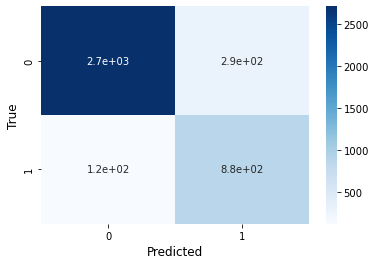

In [142]:
cf_matrix = confusion_matrix(ydev, dev_predicted)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [70]:
def test_preprocess(filename):
    header = ["test_id", "Sentence_1", "Sentence_2"]
    df = pd.read_csv(filename, quoting=3, encoding='utf8', error_bad_lines=False, names=header,
                     sep='\t')
    # Make all words lowercase
    df['Sentence_1'] = df['Sentence_1'].str.lower()
    df['Sentence_2'] = df['Sentence_2'].str.lower()
    return df

In [135]:
test_data = test_preprocess("test_without_label.txt")
Xtest = all_features(test_data["Sentence_1"], test_data["Sentence_2"])
Xoutput = pd.DataFrame()
Xoutput['test_id'] = test_data["test_id"]
Xoutput['prediction'] = gs.predict(Xtest)
Xoutput.to_csv("OwenFitzgeraldKing_test_result.txt", sep='\t', index=False, header=False)


125/125 [==============================] - 0s 2ms/step
